# A Computationally Efficient Digital Twin of a Vehicle Energy Consumption Model

Complete Jupyter notebook with all steps and results.

Chapters:
- Importing libraries
- Functions for preprocessing
- Importing data
- Data Analysis
- Preprocessing data
- Building two neural networks and comparing the results
- Optimization of best model
- Showing of best results


## Importing libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
from scipy.io import matlab, loadmat
import time

# Libraries for visualization of data
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Algorithms and neural networks
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization

# Preprocessing and optimization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Regression Metric
from sklearn.metrics import r2_score

# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=matlab.MatReadWarning)

## Preprocessing functions

Three functions are needed. One for importing the data, one for introducing the timesteps and one for padding or trimming the datasets.

In [2]:
def import_data(path, name_list, var_list):
    """
    This function imports the data from a matlab workspace and loads them into Python. The correct samples are selected based on the given list of file names and the list of variables. 
    All data from the filenamelist is concatenated after each other to make one long dataframe.

    Parameters:
        file_path (string): Contains the filepath of the stored matlab workspaces
        name_list (list)  : All the filenames from which data should be selected. Files should be of the .mat format
        var_list (list)   : Contains all names of the variables to be imported.

    Returns:
        final_data (pd.DataFrame): Imported and selected data
    """
    final_data = pd.DataFrame() # General dataframe for the final imported data

    # Loop over the filenames which belong to the filenamelist
    for name in name_list:
        df_file = pd.DataFrame() # Initiate intermediate dataframe which will contain the data from one file

        # Construct file path dependent on the file name and path
        file_path = f"{path}\{name}.mat"
        
        # Load the data
        data = loadmat(file_path)
        
        # Loop over the variables
        for var in var_list:
            df_var = pd.DataFrame() # Initiate second intermediate dataframe which will contain the data from one variable
            
            if var == 'OUT_TBATT':
                # This variable has ten times too many data points so has to be downsized. This is the reason of the [::10] at the end
                var_data = data[var][0][0][1][0][0][0][::10]
            else:
                var_data = data[var][0][0][1][0][0][0] # This indexation is used to locate the values of the data in the nested Matlab arrays.

            df_var = pd.DataFrame(var_data, columns=[var]) # Store the data in a temporary dataframe
            df_var.dropna(inplace=True) # Remove the NaN datapoints    

            df_file = pd.concat([df_file, df_var], axis=1) # Concatenate the data from this variable into the filename dataframe (along the columns)

        # Store the data in the general dataframe
        final_data = pd.concat([final_data, df_file], axis=0, ignore_index=True) # Concatenate the filename dataframe horizontally along the rows
    return final_data

In [3]:
def add_mean(df, mean_var, avg_num):
    """
    This function adds the moving average of a variable to the dataframe.

    Parameters:
        df (pd.DataFrame): All data before transformation
        mean_var (string): Name of the variable whereof the moving average has to be added
        avg_num (integer): Number of samples used in the moving average
    
    Returns:
        df (pd.DataFrame): Edited data with the added moving average column
    """
    moving_avg = []
    mean_name = f"{mean_var}mean"

    moving_avg[:avg_num] = df[mean_var][:avg_num]

    for i in range(avg_num,len(df[mean_var])):
        moving_avg.append(np.mean(df[mean_var][i-avg_num:i]))

    df[mean_name] = moving_avg
    return df

In [4]:
def timestep_data(data, n_timesteps, n_features):
    """
    This function introduces a timestep into the input data to create a moving average. Then previous datapoints are used to make the current prediction.
    This will improve the performance of the model

    Parameters:
        data (pd.DataFrame or nd.ndarray): Input data to be timestepped
        n_timesteps (integer)            : Number of timesteps that the data will be shifted
        n_features (integer)             : Number of variables of the data
    
    Returns:
        timestepped_data (nd.array): Timestepped data array
    """
    if isinstance(data, pd.DataFrame): # Check if the input data is a dataframe
        data_array = data.to_numpy() # Convert DataFrame to array
    elif isinstance(data, np.ndarray):
        data_array = data # If the data is an array type, no action is needed

    # Define the number of samples
    n_samples = data_array.shape[0] - n_timesteps + 1

    # Initialize an empty array to store the reshaped data
    timestepped_data = np.empty((n_samples, n_timesteps, n_features))

    # Reshape the data
    for i in range(n_samples):
        timestepped_data[i] = data_array[i:i+n_timesteps, :] # This step performs the timestep shifting

    # Now 'timestepped_data' contains the input data in the desired format
    print("Shape of reshaped data:", timestepped_data.shape)
    return timestepped_data

In [5]:
def pad_data(data, target_shape):
    """
    Pad or trim the data to reach the target shape.

    Parameters:
        data (numpy.ndarray): Input data array.
        target_shape (tuple): Target shape for the data.

    Returns:
        data (numpy.ndarray): Padded or trimmed data array.
    """
    current_shape = data.shape
    if current_shape[0] == target_shape[0]:
        return data  # No padding or trimming needed

    if current_shape[0] < target_shape[0]:
        # Pad the data to reach the target shape by repeating the last sample
        pad_rows = target_shape[0] - current_shape[0]
        last_sample = data[-1:]
        padded_data = np.repeat(last_sample, pad_rows, axis=0)

        return np.concatenate([data, padded_data], axis=0)
    
    elif current_shape[0] > target_shape[0]:
        # Trim excess rows from the data to match the target shape
        trimmed_data = data[:target_shape[0]]

        return trimmed_data

In [6]:
def charging_events(data):
    """
    This function counts how many times the battery is charging based on the state of charge

    Parameters:
        data (numpy.ndarray): output dataset containing the State of Charge and the energy consumption

    Returns:
        n_charging_events(integer): number of charging events recognised in the SoC
    """
    n_charging_events = 0
    charging = False
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=['OUT_SOC', 'OUT_NRG'])
    for soc_value in data['OUT_SOC']:
        # If the SoC goes below 20%, the battery should start charging, if it isn't already
        if soc_value < 40:
            if not charging:
                # print('CHARGING EVENT')
                charging = True
        elif soc_value > 65 and charging:
            charging = False
            n_charging_events += 1
    return n_charging_events

## Importing

First the necessary lists and variables are defined. Then, the importing function is used.

In [7]:
# Specify the file names
file_names= [
    'Coach',
    'HeavyUrban',
    'Interurban',
    'LongHaul',
    'MunicipalUtility',
    'RegionalDelivery',
    'Suburban',
    'Urban',
    'UrbanDelivery'
]

# Define the path with the workspaces so place the Matlab workspaces in the same folder as this code in a folder called Workspaces
path = "Workspaces"

# Define the variable lists
var_list = ['OUT_BATT_V','OUT_SPEED_REAL', 'OUT_TAMB', 'OUT_TBATT', 'OUT_MOTOR_T', 'OUT_BATT_P', 'OUT_SOC', 'OUT_NRG']
output_var_list = ['OUT_SOC', 'OUT_NRG']

In [8]:
data = import_data(path, file_names, var_list)

## Data Analysis

In [9]:
data.head(10)

,OUT_BATT_V,OUT_SPEED_REAL,OUT_TAMB,OUT_TBATT,OUT_MOTOR_T,OUT_BATT_P,OUT_SOC,OUT_NRG
0,500.00,0.00,13.00,0.00,0.00,0.00,0.00,0.00
1,779.61,0.00,13.00,24.99,0.00,58.63,80.00,0.00
2,779.60,0.00,13.00,24.98,0.00,129.55,80.00,0.00
3,777.56,1.20,13.00,24.96,400.00,41674.93,80.00,0.00
4,770.46,2.19,13.00,24.96,400.00,73868.13,79.99,0.02
5,767.04,3.18,13.00,24.97,400.00,97205.06,79.97,0.04
6,764.00,4.17,13.00,24.99,400.00,117236.24,79.94,0.07
7,760.71,5.16,13.00,25.04,400.00,140515.72,79.91,0.11
8,757.30,6.15,13.00,25.10,400.00,163935.36,79.87,0.15
9,753.79,7.14,13.00,25.20,400.00,187726.58,79.82,0.20


The velocity profiles are first analyzed. This information cna be used to determine which profiles will be used for training, validation and testing.

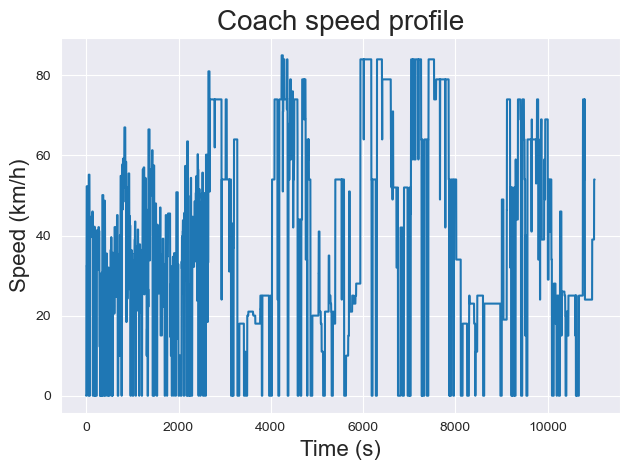

In [11]:
data = pd.read_csv(f"Driving Cycles\Coach.csv")

# Plot the data
plt.plot(data['Time'], data[' Speed'])

# Set labels and title for each subplot
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Speed (km/h)', fontsize=16)
plt.title('Coach speed profile', fontsize=20)
plt.tight_layout()
plt.show()

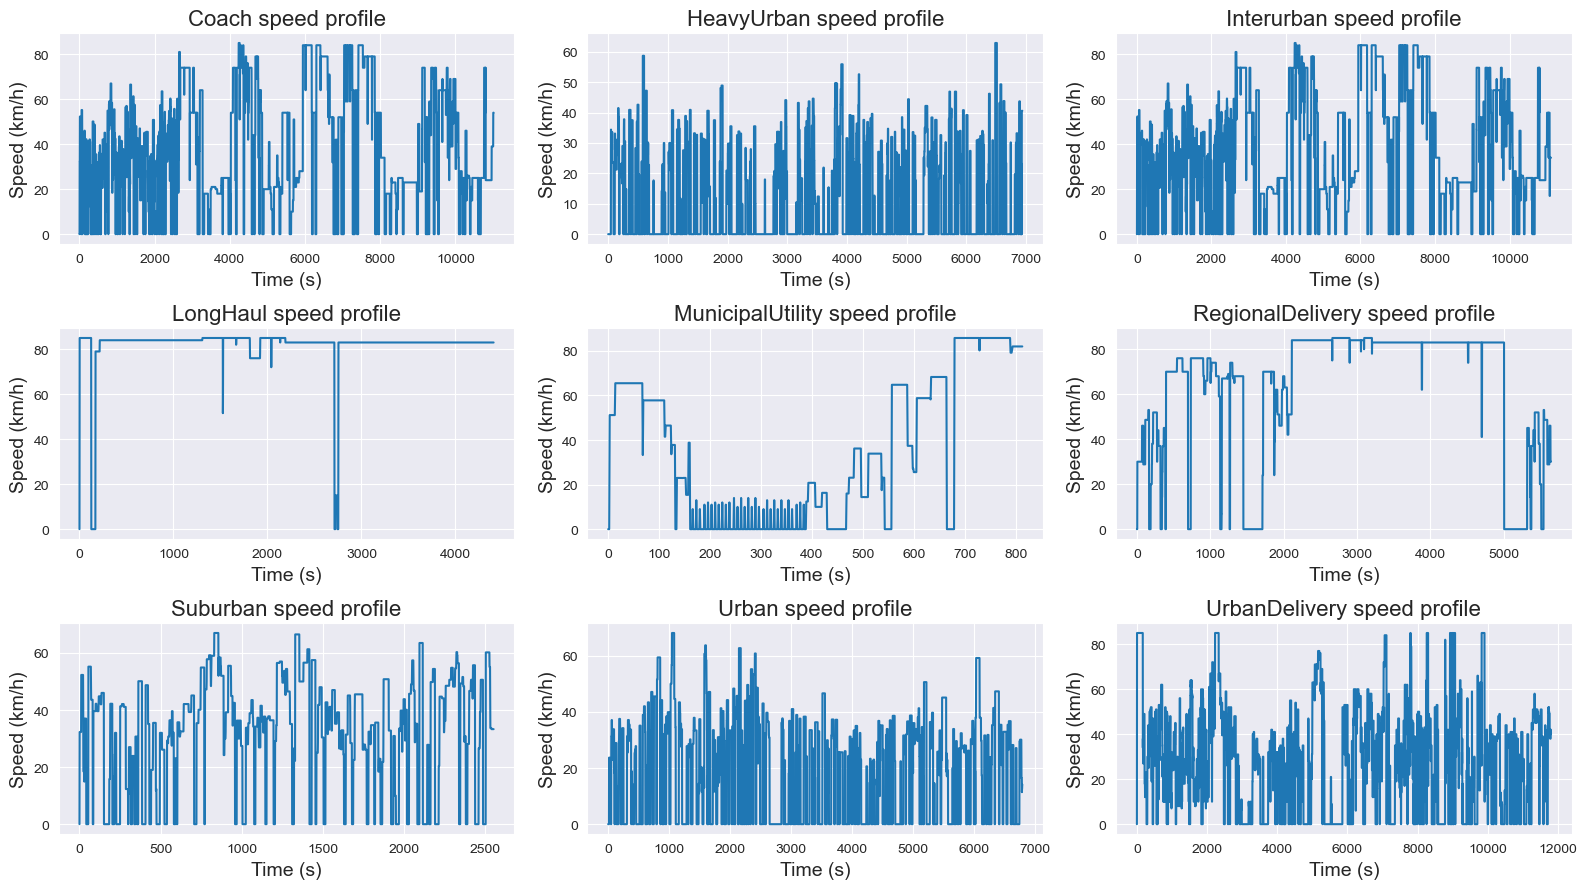

In [13]:
# Create a new figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(16, 9))

# Loop over the file names and corresponding subplot axes
for file_name, ax in zip(file_names, axes.ravel()):
    # Read the CSV file
    data = pd.read_csv(f"Driving Cycles\{file_name}.csv")
    
    # Plot the data
    ax.plot(data['Time'], data[' Speed'])
    
    # Set labels and title for each subplot
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Speed (km/h)', fontsize=14)
    ax.set_title(f'{file_name} speed profile', fontsize=16)
    
plt.tight_layout()

# Show the plot
plt.show()

Next, the state of charge profiles can be used to confirm if anything went wrong in generation the data.

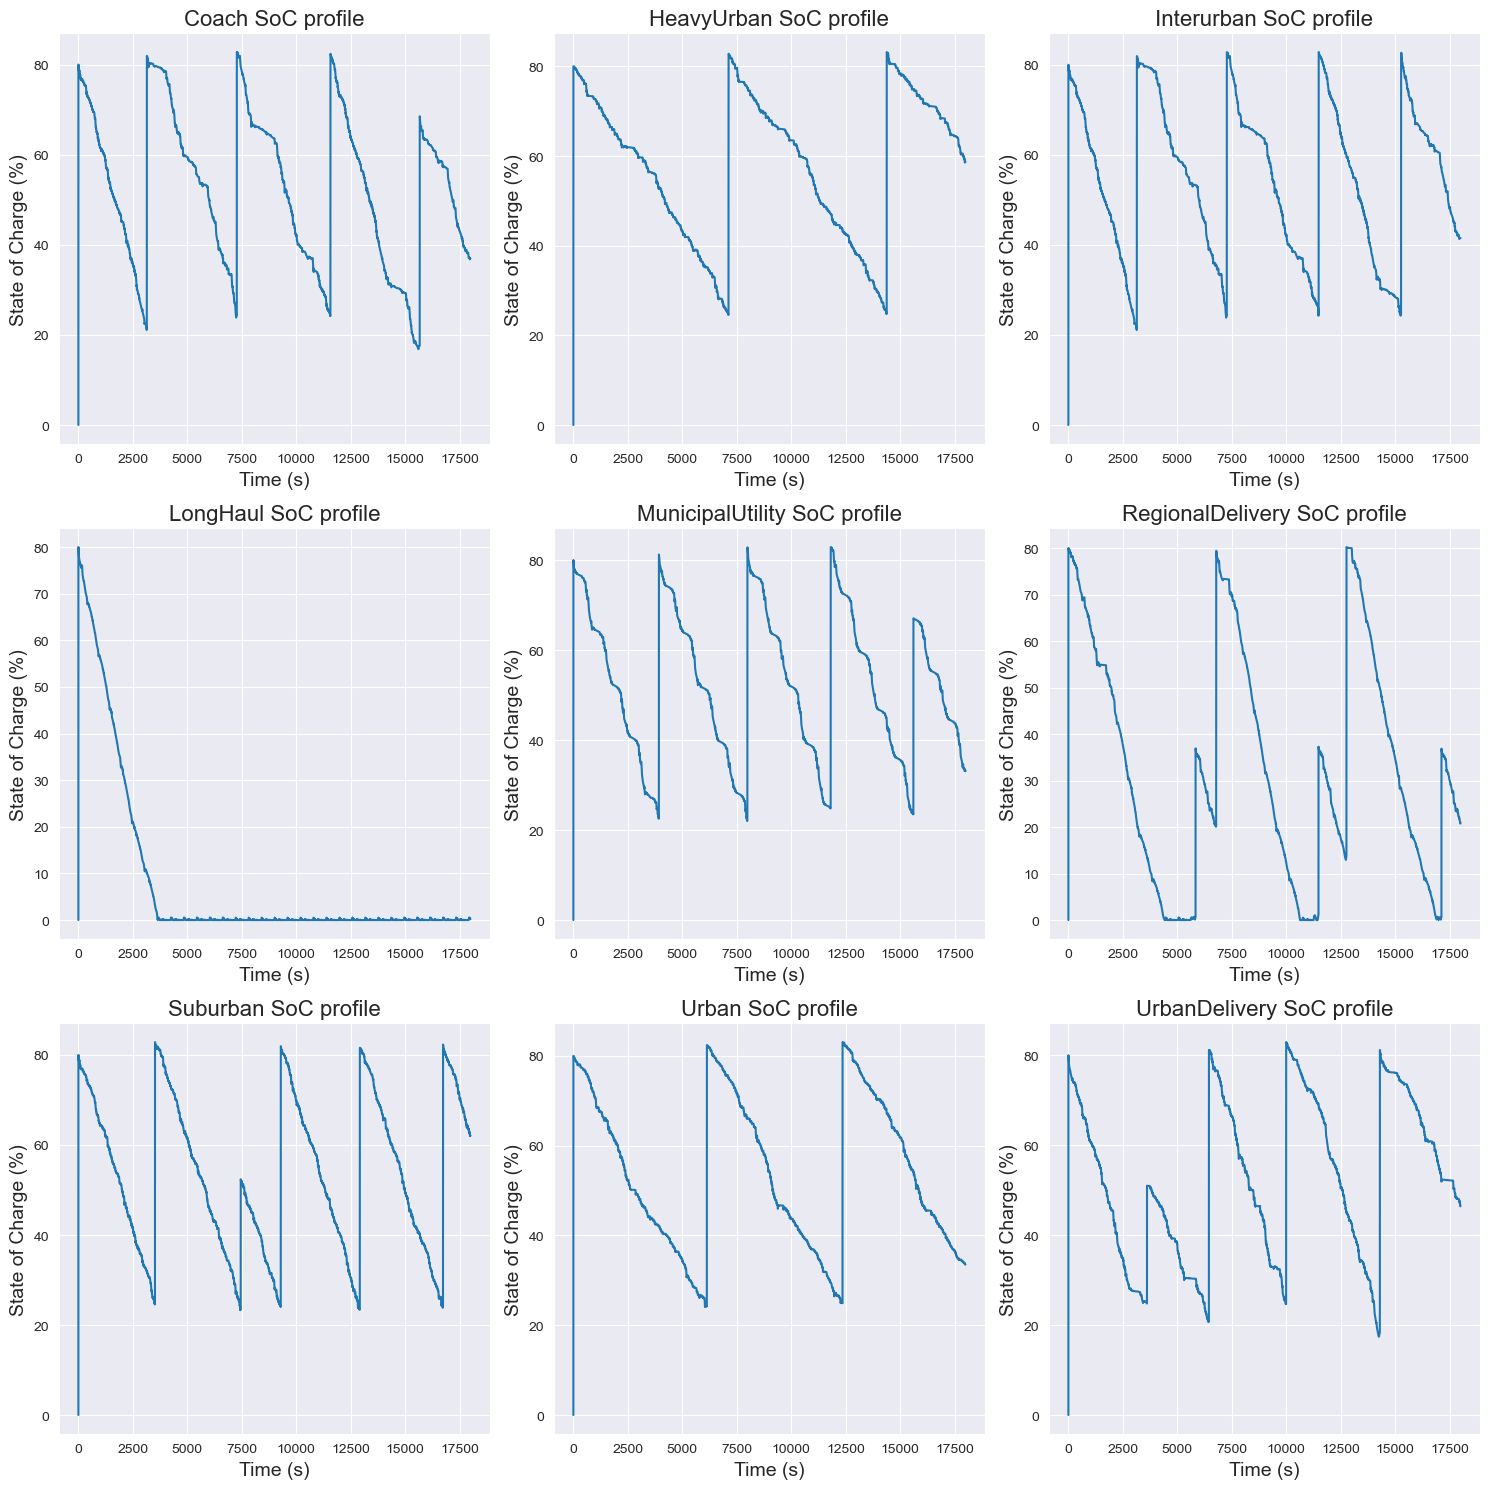

In [14]:
# Create a new figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Loop over the file names and corresponding subplot axes
for file_name, ax in zip(file_names, axes.ravel()):
    # Import the SoC data
    file_SOC = import_data(path, [file_name], ['OUT_SOC'])
    
    # Plot the data
    ax.plot(file_SOC)
    
    # Set labels and title for each subplot
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('State of Charge (%)', fontsize=14)
    ax.set_title(f'{file_name} SoC profile', fontsize=16)
    
plt.tight_layout()

# Show the plot
plt.show()

It can be concluded that in the LongHaul driving cycle, the vehicle isn't standing still for long enough to be able to charge the battery. This results in faulty data since the model couldn't handle a zero SoC and what it meant. This speed profile will consequently be excluded from training the model.

In [15]:
file_names = ['Coach','HeavyUrban','Interurban','MunicipalUtility','RegionalDelivery','Suburban','Urban','UrbanDelivery']
data = import_data(path, file_names, var_list)

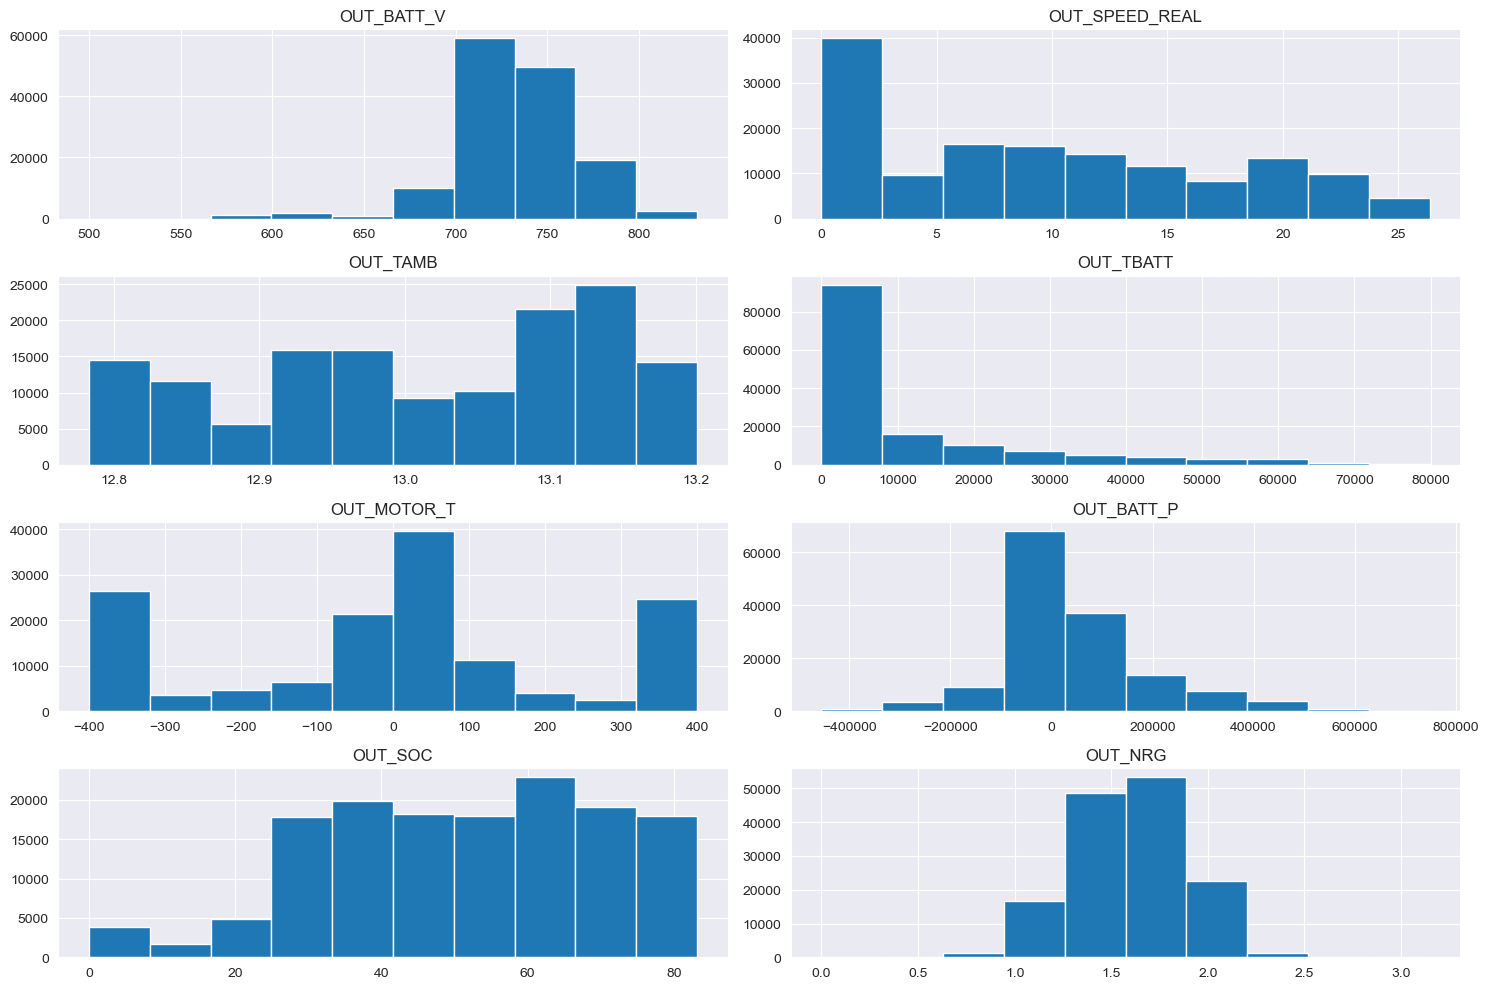

In [16]:
data.hist(figsize=(15,10), layout=(4,2))
plt.tight_layout()
plt.show()

It can already be noted that the battery temperature has values that are not physical. Temperatures above 20000 are not as expected in a vehicle. Consequently, this feature will later be removed.

In [17]:
data.describe()

,OUT_BATT_V,OUT_SPEED_REAL,OUT_TAMB,OUT_TBATT,OUT_MOTOR_T,OUT_BATT_P,OUT_SOC,OUT_NRG
count,144008.00,144008.00,144008.00,144008.00,144008.00,144008.00,144008.00,144008.00
mean,733.07,9.64,13.01,10436.79,3.70,48830.14,51.24,1.58
std,33.19,7.90,0.12,15309.47,252.24,138768.44,19.30,0.31
min,500.00,0.00,12.78,0.00,-400.00,-455320.27,0.00,0.00
25%,718.18,0.66,12.92,51.96,-134.79,1418.34,36.73,1.45
50%,731.74,9.12,13.03,2920.82,20.21,10372.40,52.24,1.59
75%,752.39,15.89,13.12,14595.97,109.76,94659.13,66.87,1.68
max,831.60,26.36,13.20,79875.74,400.00,748440.00,83.18,3.15


Correlation matrix and heatmap of the complete dataset.

In [18]:
data.corr()

,OUT_BATT_V,OUT_SPEED_REAL,OUT_TAMB,OUT_TBATT,OUT_MOTOR_T,OUT_BATT_P,OUT_SOC,OUT_NRG
OUT_BATT_V,1.00,-0.35,-0.12,0.54,-0.32,-0.42,0.80,0.31
OUT_SPEED_REAL,-0.35,1.00,-0.01,0.01,0.31,0.23,-0.24,-0.40
OUT_TAMB,-0.12,-0.01,1.00,0.01,0.02,-0.00,-0.14,-0.03
OUT_TBATT,0.54,0.01,0.01,1.00,0.01,0.02,0.57,-0.12
OUT_MOTOR_T,-0.32,0.31,0.02,0.01,1.00,0.73,-0.03,-0.06
OUT_BATT_P,-0.42,0.23,-0.00,0.02,0.73,1.00,-0.01,-0.04
OUT_SOC,0.80,-0.24,-0.14,0.57,-0.03,-0.01,1.00,0.32
OUT_NRG,0.31,-0.40,-0.03,-0.12,-0.06,-0.04,0.32,1.00


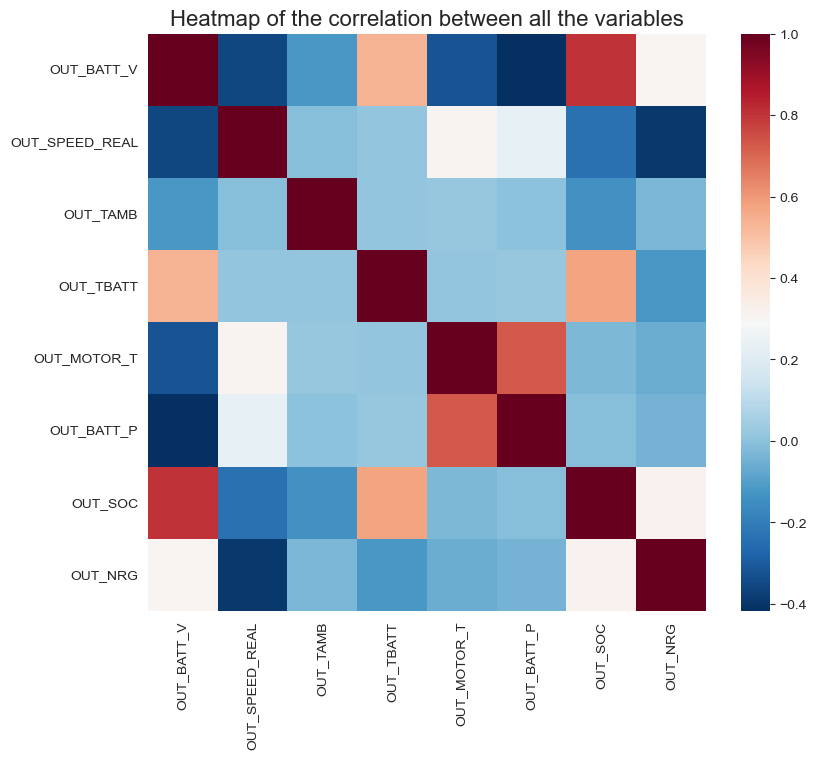

In [19]:
plt.figure(figsize=(9,7.5))
sns.heatmap(data.corr(), cmap='RdBu_r')
plt.title('Heatmap of the correlation between all the variables', fontsize=16)
plt.show()

This figure gives interesting information. The SoC has a strong correlation with the battery voltage and also the battery temperature. Sadly, the battery temperature will have to be deleted for previously mentioned reasons. Also, the energy consumption does not show any strong correlation with any other variable. This will give problems in trying to predict it.

What remains is variables that are barely correlated to the variables to be predicted. The SoC prediction barely benefits from all the other variables besides the voltage. 

## Preprocessing

The preprocessing functions are applied to the imported data. This is the order of things:
- Splitting in testing, validation and testing datasets
- Adding moving average
- Splitting in input and output data
- Normalizing
- Timeshifting
- Padding or trimming

In [20]:
# Make a list with the filenames of the velocity profiles to be used for either training, validation or testing
trainname_list = ['Suburban', 'Urban', 'RegionalDelivery']
validatename_list = ['Interurban']
testname_list = ['Coach', 'HeavyUrban', 'UrbanDelivery', 'MunicipalUtility']

# Define the amount of velocity profiles that are used for training, validation and testing
train_n = len(trainname_list)
validate_n = len(validatename_list)
test_n = len(testname_list)

In [21]:
train = import_data(path, trainname_list, var_list)
validation = import_data(path, validatename_list, var_list)
test = import_data(path, testname_list, var_list)

In [22]:
# A moving average column is added to the input data
input_sets = [train, validation, test]
mean_vars = ['OUT_BATT_V', 'OUT_SPEED_REAL']
n_moving_avg = 50

for set in input_sets:
    for mean_var in mean_vars:
        add_mean(set, mean_var, n_moving_avg)

In [23]:
# The output datasets are defined as the datapoints to be predicted
y_train = train[['OUT_SOC', 'OUT_NRG']]
y_validation = validation[['OUT_SOC', 'OUT_NRG']] 
y_test = test[['OUT_SOC', 'OUT_NRG']]

# The input datasets are all the other variables that were imported, minus the battery temperature
X_train = train.drop(['OUT_SOC', 'OUT_NRG', 'OUT_TBATT'], axis=1)
X_validation = validation.drop(['OUT_SOC', 'OUT_NRG', 'OUT_TBATT'], axis=1)
X_test = test.drop(['OUT_SOC', 'OUT_NRG', 'OUT_TBATT'], axis=1)

The number of timesteps and the number of features are the only parameters to be defined before preprocessing. The rest comes later.

In [24]:
n_timesteps = 25
n_features = X_train.shape[1]
n_outputs = y_train.shape[1]

In [25]:
# The input data is normalized
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [26]:
# Timeshifting the input datasets is only needed for the LSTM network. The Dense input datasets are therefore separated beforehand.
desired_shape_train = (54000, n_features)
desired_shape_validation = (18000, n_features)
desired_shape_test = (72000, n_features)

# Pad the input datasets
X_train_Dense = pad_data(X_train, desired_shape_train)
X_validation_Dense = pad_data(X_validation, desired_shape_validation)
X_test_Dense = pad_data(X_test, desired_shape_test)

# The LSTM datasets don't get a specific name
X_train = timestep_data(X_train, n_timesteps, n_features)
X_validation = timestep_data(X_validation, n_timesteps, n_features)
X_test = timestep_data(X_test, n_timesteps, n_features)

desired_shape_train = (54000, n_timesteps, n_features)
desired_shape_validation = (18000, n_timesteps, n_features)
desired_shape_test = (72000, n_timesteps, n_features)

# Pad the input datasets
X_train = pad_data(X_train, desired_shape_train)
X_validation = pad_data(X_validation, desired_shape_validation)
X_test = pad_data(X_test, desired_shape_test)

# Pad the output datasets
y_train = pad_data(y_train, (54000, n_outputs))
y_validation = pad_data(y_validation, (18000, n_outputs))
y_test = pad_data(y_test, (72000, n_outputs))

Shape of reshaped data: (53979, 25, 7)
Shape of reshaped data: (17977, 25, 7)
Shape of reshaped data: (71980, 25, 7)


## Building the neural networks

A Feed forward and a Recurrent neural network will be built and compared to each other.
The feed forward network will contain solely dense layers. The recurrent network will have LSTM layers for pattern recognition and a dense layer as output layer.

In [27]:
# The Feed forward neural network
class DenseNNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, batchsize):
        self.batch_size = batchsize
        self.model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train_Dense.shape[1],)),
            Dense(32, activation='relu'),
            Dense(2)  # Output layer
        ])
        self.model.compile(optimizer='adam', loss='mse')
    
    def fit(self, X, y, Xval, yval):
        history = self.model.fit(X, y, epochs=5, validation_data=(Xval, yval),batch_size=self.batch_size)
        return self, history
    
    def predict(self, X):
        return self.model.predict(X, batch_size = self.batch_size)
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, batch_size = self.batch_size)

In [28]:
class LSTMTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, batchsize, n_timesteps, n_features, dropout_rate):

        self.n_timesteps = n_timesteps
        self.batch_size = batchsize

        self.model = Sequential([
            LSTM(64, activation='tanh', batch_input_shape=(batchsize, n_timesteps, n_features), dropout=dropout_rate),
            Dense(2, activation='relu') # Output layer
        ])
        self.model.compile(optimizer='adam', loss='mse')

    def fit(self, X, y, Xval, yval):
        history = self.model.fit(X, y, epochs=5, validation_data=(Xval, yval), batch_size=self.batch_size)            
        return self, history
    
    def predict(self, X):
        return self.model.predict(X, batch_size = self.batch_size)
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, batch_size = self.batch_size)

In [29]:
# Define hyperparameters
batch_size = 10
dropout_rate = 0.1

timestamp_0 = time.perf_counter()
# Define feed forward model, fit, make predictions and evaluate
dense_model = DenseNNTransformer(batch_size)
dense_model, history_dense_simple = dense_model.fit(X_train_Dense, y_train, X_validation_Dense, y_validation)
dense_predictions = dense_model.predict(X_test_Dense)
dense_test_loss = dense_model.evaluate(X_test_Dense, y_test)

Epoch 1/5
5400/5400 [==============================] - 17s 3ms/step - loss: 45.4405 - val_loss: 7.7905
Epoch 2/5
5400/5400 [==============================] - 16s 3ms/step - loss: 8.3514 - val_loss: 4.8874
Epoch 3/5
5400/5400 [==============================] - 16s 3ms/step - loss: 7.4084 - val_loss: 5.0763
Epoch 4/5
5400/5400 [==============================] - 16s 3ms/step - loss: 6.1326 - val_loss: 5.1140
Epoch 5/5
7200/7200 [==============================] - 15s 2ms/step - loss: 4.6090


In [30]:
# Define hyperparameters
batch_size = 10
dropout_rate = 0.1

timestamp_0 = time.perf_counter()
# Define feed forward model, fit, make predictions and evaluate
dense_model = DenseNNTransformer(batch_size)
dense_model, history_dense_simple = dense_model.fit(X_train_Dense, y_train, X_validation_Dense, y_validation)
dense_predictions = dense_model.predict(X_test_Dense)
dense_test_loss = dense_model.evaluate(X_test_Dense, y_test)

timestamp_1 = time.perf_counter()

# Repeat for the recurrent network
lstm_model_simple = LSTMTransformer(batch_size, n_timesteps, n_features, dropout_rate)
lstm_model_simple, history_simple_lstm = lstm_model_simple.fit(X_train, y_train, X_validation, y_validation)
lstm_predictions = lstm_model_simple.predict(X_test)
lstm_test_loss = lstm_model_simple.evaluate(X_test, y_test)

timestamp_2 = time.perf_counter()

Epoch 1/5
5400/5400 [==============================] - 17s 3ms/step - loss: 45.7242 - val_loss: 6.0721
Epoch 2/5
5400/5400 [==============================] - 16s 3ms/step - loss: 8.0352 - val_loss: 5.6019
Epoch 3/5
5400/5400 [==============================] - 15s 3ms/step - loss: 5.9863 - val_loss: 4.7698
Epoch 4/5
5400/5400 [==============================] - 16s 3ms/step - loss: 4.8692 - val_loss: 4.5226
Epoch 5/5
7200/7200 [==============================] - 17s 2ms/step - loss: 4.9175
Epoch 1/5
5400/5400 [==============================] - 69s 12ms/step - loss: 77.5385 - val_loss: 4.2750
Epoch 2/5
5400/5400 [==============================] - 65s 12ms/step - loss: 4.4363 - val_loss: 2.1581
Epoch 3/5
5400/5400 [==============================] - 64s 12ms/step - loss: 3.4629 - val_loss: 1.6619
Epoch 4/5
5400/5400 [==============================] - 64s 12ms/step - loss: 2.8819 - val_loss: 1.5896
Epoch 5/5
7200/7200 [==============================] - 40s 6ms/step - loss: 1.7956


Processing the results

Feed forward model
Test loss:  4.918
R²-score of State of Charge:  0.966
R²-score of Energy Consumption:  -0.655
Number of predicted charging events:  36 Actual charging events:  17


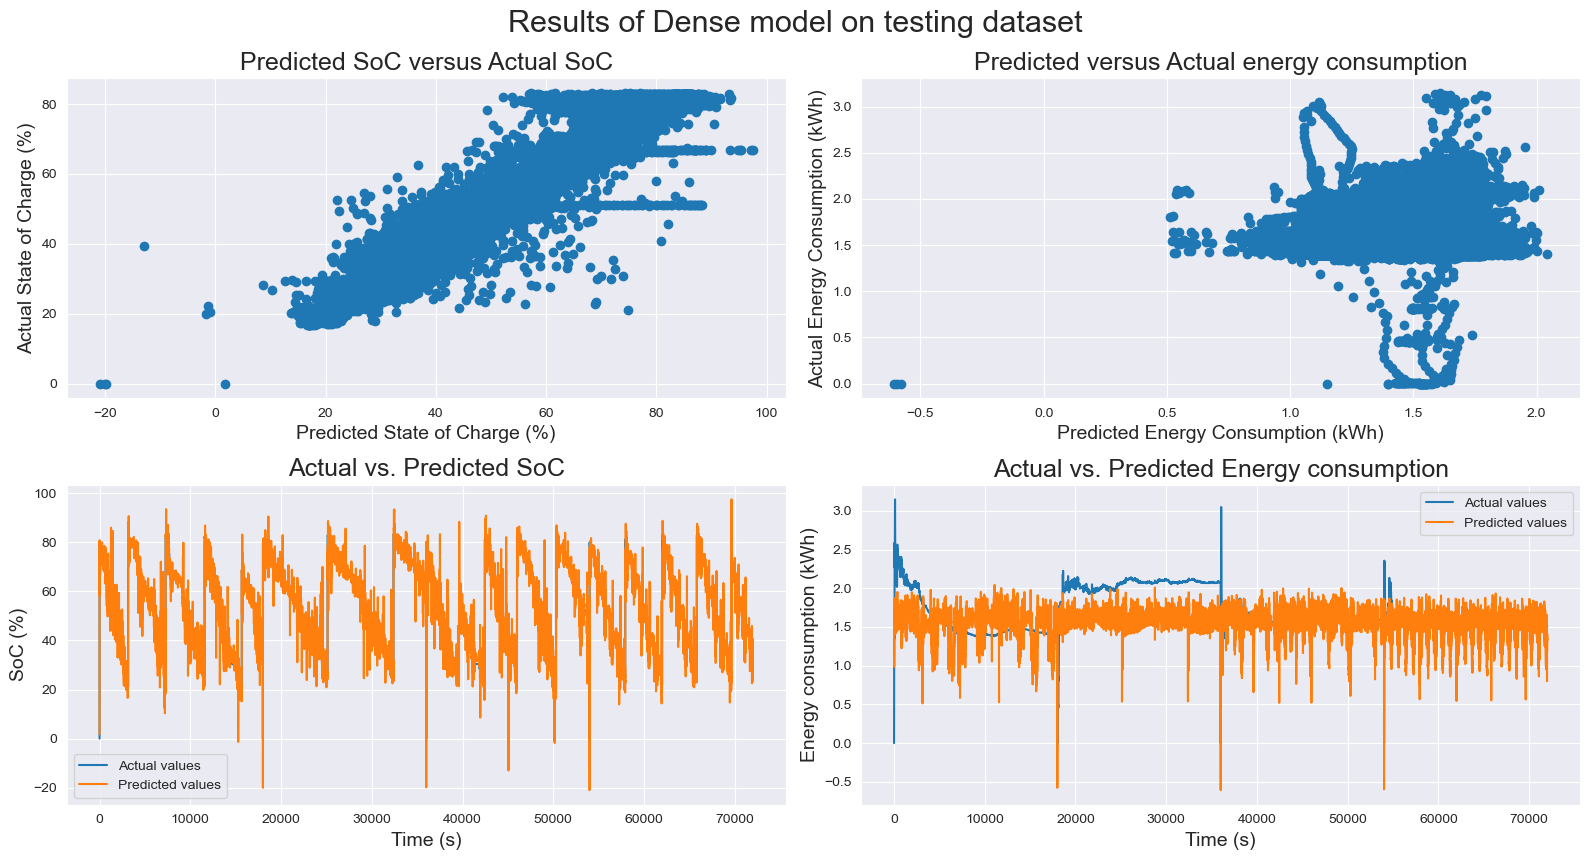

In [31]:
print("Feed forward model")
print("Test loss: ", round(dense_test_loss,3))

post_dense = pd.DataFrame(y_test, columns=output_var_list)
post_dense_pred = pd.DataFrame(dense_predictions, columns=output_var_list)

r2_soc_dense = r2_score(post_dense['OUT_SOC'], post_dense_pred['OUT_SOC'])
print("R²-score of State of Charge: ", round(r2_soc_dense,3))
r2_nrg_dense = r2_score(post_dense['OUT_NRG'], post_dense_pred['OUT_NRG'])
print("R²-score of Energy Consumption: ", round(r2_nrg_dense,3))

dense_ch_ev = charging_events(dense_predictions)
print("Number of predicted charging events: ", dense_ch_ev, "Actual charging events: ", charging_events(y_test))

label_size = 14

# Visualize predicted values in function of actual values
plt.figure(figsize=(16,9))
plt.subplot(2,2,1)
plt.scatter(post_dense_pred['OUT_SOC'], post_dense['OUT_SOC'])
plt.xlabel('Predicted State of Charge (%)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual State of Charge (%)', fontsize=label_size)
plt.title('Predicted SoC versus Actual SoC', fontsize=18)

plt.subplot(2,2,2)
plt.scatter(post_dense_pred['OUT_NRG'], post_dense['OUT_NRG'])
plt.xlabel('Predicted Energy Consumption (kWh)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual Energy Consumption (kWh)', fontsize=label_size)
plt.title('Predicted versus Actual energy consumption', fontsize=18)

# Visualize actual vs predicted values in function of time
plt.subplot(2,2,3)
plt.plot(post_dense['OUT_SOC'], label='Actual values')
plt.plot(post_dense_pred['OUT_SOC'], label='Predicted values')
plt.title('Actual vs. Predicted SoC', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('SoC (%)', fontsize=label_size)
plt.legend()

plt.subplot(2,2,4)
plt.plot(post_dense['OUT_NRG'], label='Actual values')
plt.plot(post_dense_pred['OUT_NRG'], label='Predicted values')
plt.title('Actual vs. Predicted Energy consumption', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('Energy consumption (kWh)', fontsize=label_size)
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Results of Dense model on testing dataset', fontsize=22)
plt.show()

Recurrent model
Test loss:  1.796
R²-score of State of Charge:  0.988
R²-score of Energy Consumption:  -0.55
Number of predicted charging events:  17 Actual charging events:  17


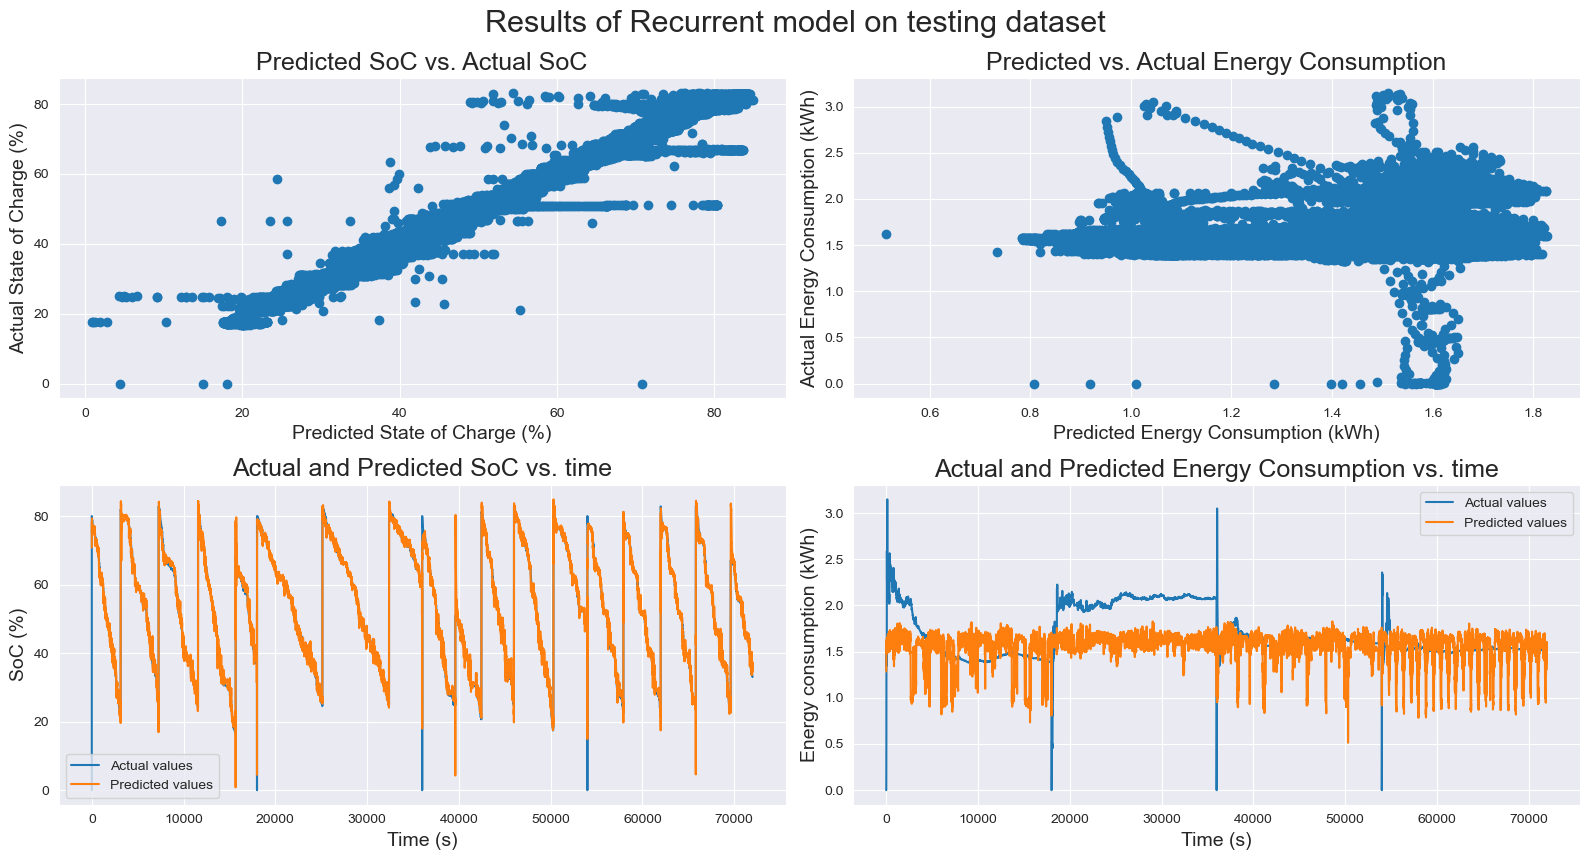

In [32]:
print("Recurrent model")
print("Test loss: ", round(lstm_test_loss,3))

post_lstm = pd.DataFrame(y_test, columns=output_var_list)
post_lstm_pred = pd.DataFrame(lstm_predictions, columns=output_var_list)

r2_soc = r2_score(post_lstm['OUT_SOC'], post_lstm_pred['OUT_SOC'])
print("R²-score of State of Charge: ", round(r2_soc,3))
r2_nrg = r2_score(post_lstm['OUT_NRG'], post_lstm_pred['OUT_NRG'])
print("R²-score of Energy Consumption: ", round(r2_nrg,3))

lstm_ch_ev = charging_events(lstm_predictions)
print("Number of predicted charging events: ", lstm_ch_ev, "Actual charging events: ", charging_events(y_test))

# Visualize predicted values in function of actual values
fig = plt.figure(figsize=(16,9))
plt.subplot(2,2,1)
plt.scatter(post_lstm_pred['OUT_SOC'], post_lstm['OUT_SOC'])
plt.xlabel('Predicted State of Charge (%)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual State of Charge (%)', fontsize=label_size)
plt.title('Predicted SoC vs. Actual SoC', fontsize=18)

plt.subplot(2,2,2)
plt.scatter(post_lstm_pred['OUT_NRG'], post_lstm['OUT_NRG'])
plt.xlabel('Predicted Energy Consumption (kWh)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual Energy Consumption (kWh)', fontsize=label_size)
plt.title('Predicted vs. Actual Energy Consumption', fontsize=18)

# Visualize actual vs predicted values in function of time
plt.subplot(2,2,3)
plt.plot(post_lstm['OUT_SOC'], label='Actual values')
plt.plot(post_lstm_pred['OUT_SOC'], label='Predicted values')
plt.title('Actual and Predicted SoC vs. time', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('SoC (%)', fontsize=label_size)
plt.legend()

plt.subplot(2,2,4)
plt.plot(post_lstm['OUT_NRG'], label='Actual values')
plt.plot(post_lstm_pred['OUT_NRG'], label='Predicted values')
plt.title('Actual and Predicted Energy Consumption vs. time', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('Energy consumption (kWh)', fontsize=label_size)
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Results of Recurrent model on testing dataset', fontsize=22)
plt.show()

In [33]:
training_time_dense = timestamp_1-timestamp_0
training_time_lstm = timestamp_2-timestamp_1

comparing_table = pd.DataFrame(columns=['Test loss', 'r2_soc', 'r2_nrg', 'Training time'])
comparing_table.loc['Feed forward'] = [dense_test_loss, r2_soc_dense, r2_nrg_dense, round(training_time_dense,2)]
comparing_table.loc['Recurrent'] = [lstm_test_loss, r2_soc, r2_nrg, round(training_time_lstm, 2)]

comparing_table.head()

,Test loss,r2_soc,r2_nrg,Training time
Feed forward,4.92,0.97,-0.65,118.20
Recurrent,1.80,0.99,-0.55,420.48


We can conclude that the recurrent neural network outperforms the feed forward model in every metric. Consequently, the RNN will be optimized.

In [34]:
print(history_dense_simple.history)

{'loss': [45.724159240722656, 8.035204887390137, 5.98634672164917, 4.869172096252441, 4.463577747344971], 'val_loss': [6.0720624923706055, 5.6018595695495605, 4.769802570343018, 4.522576808929443, 4.627100467681885]}


In [35]:
# Training Dense simple
training_pred = dense_model.predict(X_train_Dense)
training_loss = dense_model.evaluate(X_train_Dense, y_train)

5400/5400 [==============================] - 12s 2ms/step - loss: 4.0042


In [36]:
train_loss = history_dense_simple.history['loss']
validation_loss = history_dense_simple.history['val_loss']

print("Training loss: ", round(training_loss,3))

post_train = pd.DataFrame(y_train, columns=output_var_list)
post_pred_train = pd.DataFrame(training_pred, columns=output_var_list)

r2_soc_train = r2_score(post_train['OUT_SOC'], post_pred_train['OUT_SOC'])
print("R²-score of train State of Charge: ", round(r2_soc_train,3))
r2_nrg_train = r2_score(post_train['OUT_NRG'], post_pred_train['OUT_NRG'])
print("R²-score of Energy Consumption: ", round(r2_nrg_train,3))

charg_ev_train = charging_events(training_pred)
print("Number of predicted charging events: ", charg_ev_train, "Actual charging events: ", charging_events(y_train))

Training loss:  4.004
R²-score of train State of Charge:  0.984
R²-score of Energy Consumption:  0.653
Number of predicted charging events:  17 Actual charging events:  11


In [37]:
n_epochs = 5
epochs=np.linspace(1,n_epochs, n_epochs)
# print(int(epochs))
print(epochs)
epochs = [1,2,3,4,5]
print(epochs)

[1. 2. 3. 4. 5.]
[1, 2, 3, 4, 5]


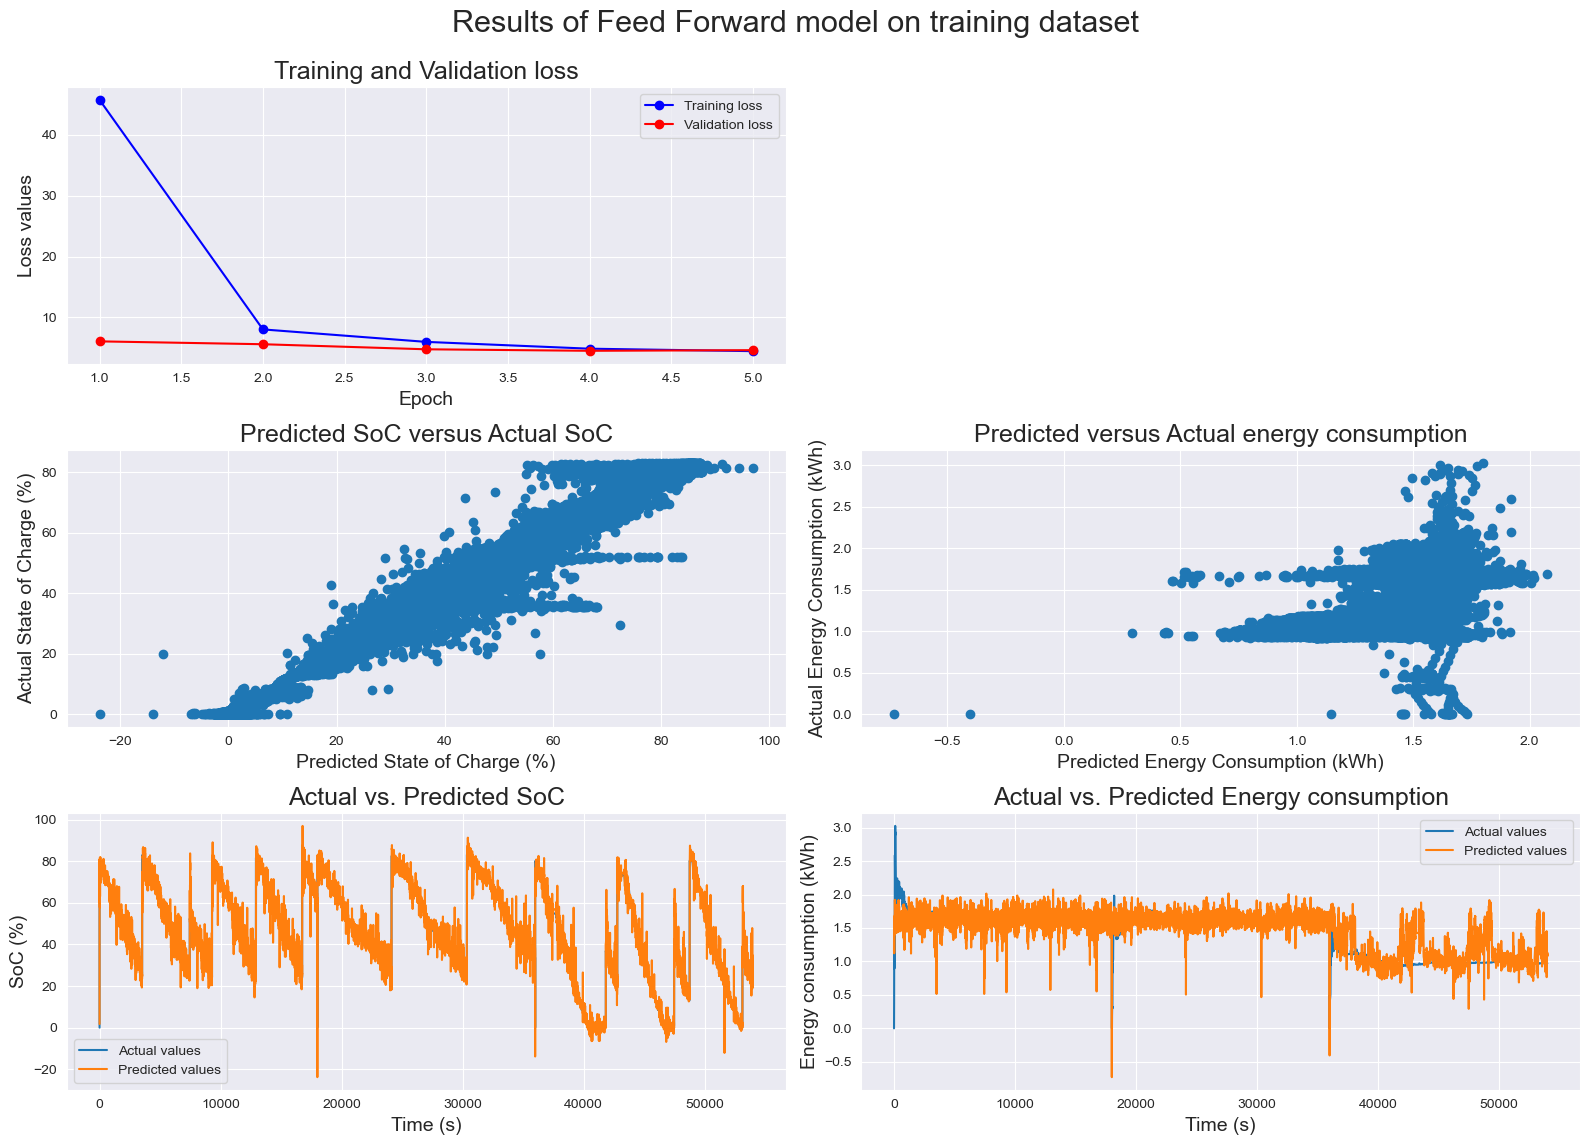

In [38]:
# Visualize predicted values in function of actual values
fig = plt.figure(figsize=(16,12))

plt.subplot(3,2,1)
plt.plot(epochs, train_loss, 'bo-',label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.xlabel('Epoch', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Loss values', fontsize=label_size)
plt.title('Training and Validation loss', fontsize=18)
plt.legend()

plt.subplot(3,2,3)
plt.scatter(post_pred_train['OUT_SOC'], post_train['OUT_SOC'])
plt.xlabel('Predicted State of Charge (%)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual State of Charge (%)', fontsize=label_size)
plt.title('Predicted SoC versus Actual SoC', fontsize=18)

plt.subplot(3,2,4)
plt.scatter(post_pred_train['OUT_NRG'], post_train['OUT_NRG'])
plt.xlabel('Predicted Energy Consumption (kWh)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual Energy Consumption (kWh)', fontsize=label_size)
plt.title('Predicted versus Actual energy consumption', fontsize=18)

# Visualize actual vs predicted values in function of time
plt.subplot(3,2,5)
plt.plot(post_train['OUT_SOC'], label='Actual values')
plt.plot(post_pred_train['OUT_SOC'], label='Predicted values')
plt.title('Actual vs. Predicted SoC', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('SoC (%)', fontsize=label_size)
plt.legend()

plt.subplot(3,2,6)
plt.plot(post_train['OUT_NRG'], label='Actual values')
plt.plot(post_pred_train['OUT_NRG'], label='Predicted values')
plt.title('Actual vs. Predicted Energy consumption', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('Energy consumption (kWh)', fontsize=label_size)
plt.legend()

# Adjust layout and add the overall title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Results of Feed Forward model on training dataset', fontsize=22)

plt.show()

In [39]:
#Training LSTM simple
training_pred = lstm_model_simple.predict(X_train)
training_loss = lstm_model_simple.evaluate(X_train, y_train)

5400/5400 [==============================] - 30s 5ms/step - loss: 1.7379


In [40]:
train_loss = history_simple_lstm.history['loss']
validation_loss = history_simple_lstm.history['val_loss']

print("Training loss: ", round(training_loss,3))

post_train = pd.DataFrame(y_train, columns=output_var_list)
post_pred_train = pd.DataFrame(training_pred, columns=output_var_list)

r2_soc_train = r2_score(post_train['OUT_SOC'], post_pred_train['OUT_SOC'])
print("R²-score of train State of Charge: ", round(r2_soc_train,3))
r2_nrg_train = r2_score(post_train['OUT_NRG'], post_pred_train['OUT_NRG'])
print("R²-score of Energy Consumption: ", round(r2_nrg_train,3))

charg_ev_train = charging_events(training_pred)
print("Number of predicted charging events: ", charg_ev_train, "Actual charging events: ", charging_events(y_train))

Training loss:  1.738
R²-score of train State of Charge:  0.993
R²-score of Energy Consumption:  0.685
Number of predicted charging events:  12 Actual charging events:  11


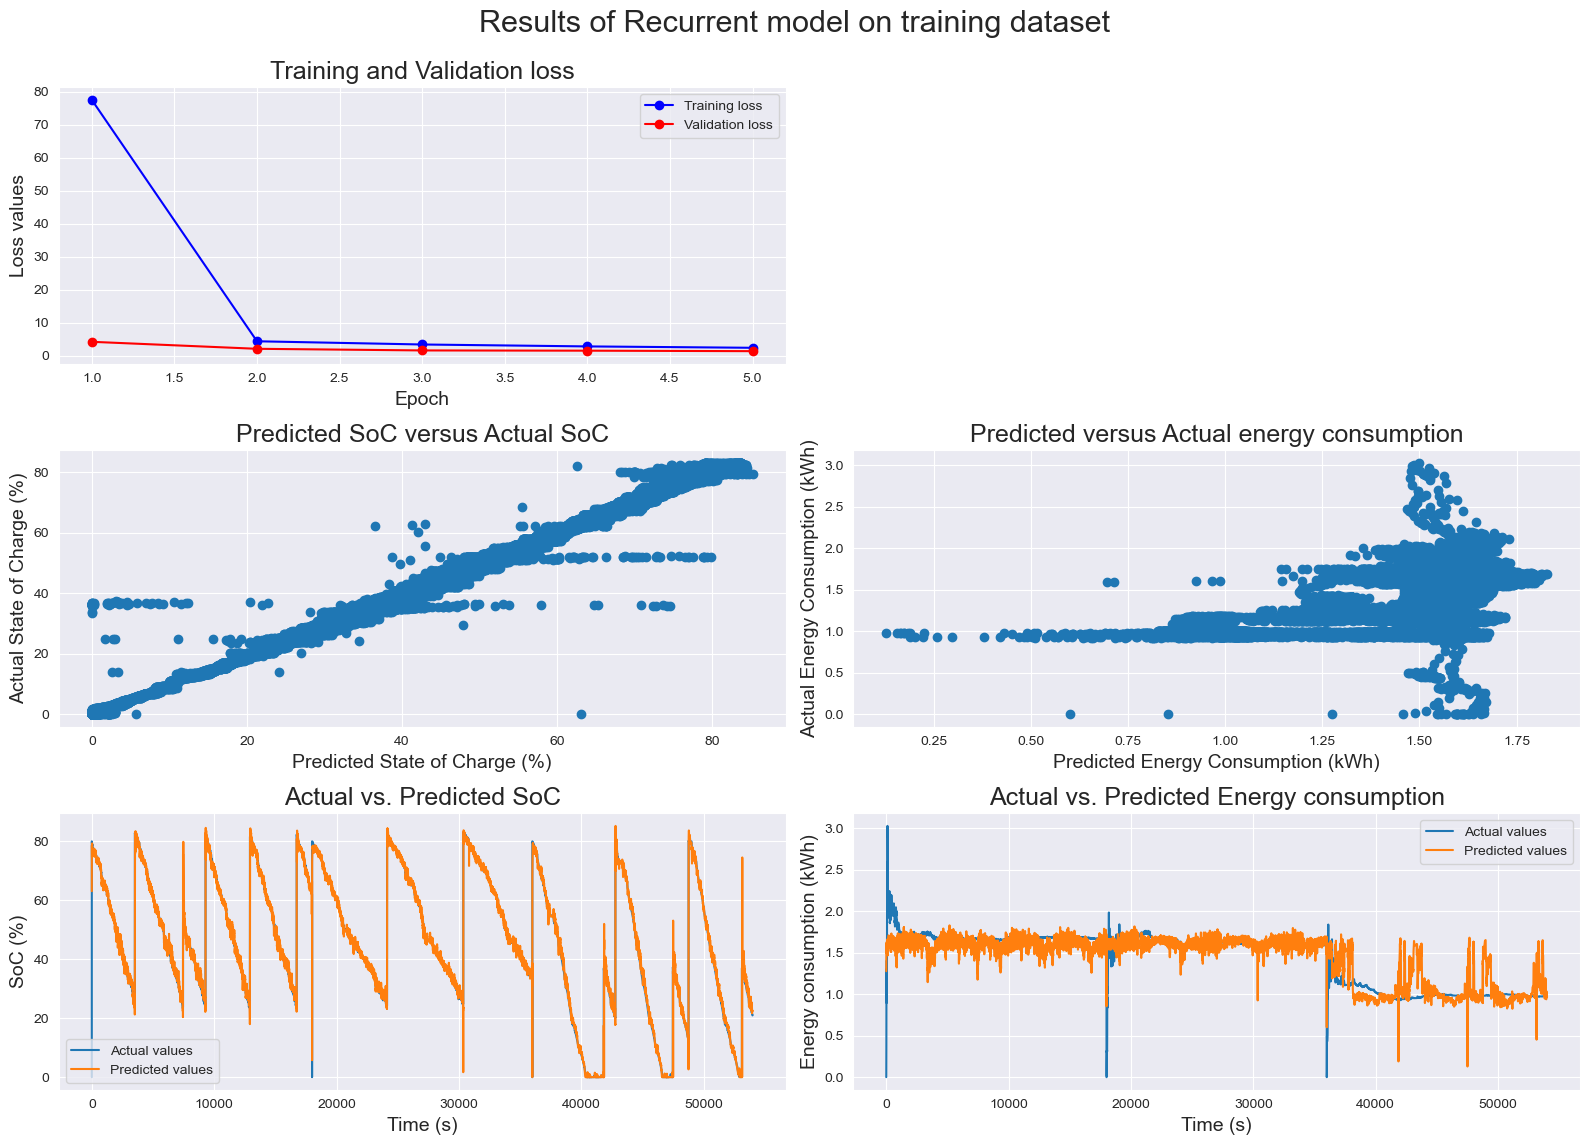

In [41]:
# Visualize predicted values in function of actual values
fig = plt.figure(figsize=(16,12))

plt.subplot(3,2,1)
plt.plot(epochs, train_loss, 'bo-',label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.xlabel('Epoch', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Loss values', fontsize=label_size)
plt.title('Training and Validation loss', fontsize=18)
plt.legend()

plt.subplot(3,2,3)
plt.scatter(post_pred_train['OUT_SOC'], post_train['OUT_SOC'])
plt.xlabel('Predicted State of Charge (%)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual State of Charge (%)', fontsize=label_size)
plt.title('Predicted SoC versus Actual SoC', fontsize=18)

plt.subplot(3,2,4)
plt.scatter(post_pred_train['OUT_NRG'], post_train['OUT_NRG'])
plt.xlabel('Predicted Energy Consumption (kWh)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual Energy Consumption (kWh)', fontsize=label_size)
plt.title('Predicted versus Actual energy consumption', fontsize=18)

# Visualize actual vs predicted values in function of time
plt.subplot(3,2,5)
plt.plot(post_train['OUT_SOC'], label='Actual values')
plt.plot(post_pred_train['OUT_SOC'], label='Predicted values')
plt.title('Actual vs. Predicted SoC', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('SoC (%)', fontsize=label_size)
plt.legend()

plt.subplot(3,2,6)
plt.plot(post_train['OUT_NRG'], label='Actual values')
plt.plot(post_pred_train['OUT_NRG'], label='Predicted values')
plt.title('Actual vs. Predicted Energy consumption', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('Energy consumption (kWh)', fontsize=label_size)
plt.legend()

# Adjust layout and add the overall title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Results of Recurrent model on training dataset', fontsize=22)

plt.show()

## Optimization

The optimization starts with defining a new class which will be used for optimizing. The optimization is performed using GridSearchCV

In [42]:
class LSTMOptimizer(BaseEstimator, TransformerMixin):
    def __init__(self, n_timesteps, batch_size, n_features, n_neurons, n_layers, activation, dropout_rate, batch_norm, state_norm, optim=True):

        self.n_timesteps = n_timesteps
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.batch_norm = batch_norm
        self.state_norm = state_norm
        self.optim = optim

        if optim:
            n_output_neurons = 1 # Perform optimization with only the SoC as output variable
            n_epochs = 3 # Reduce the number of epochs to significantly reduce optimization time
        else:
            n_output_neurons = 2 # The optimized result should include the energy consumption as well
            n_epochs = 10
        
        self.n_epochs = n_epochs

        self.model = Sequential()
        if n_layers == 1:
            self.model.add(LSTM(n_neurons, activation=activation, batch_input_shape=(batch_size, n_timesteps, n_features),dropout=dropout_rate, stateful=state_norm))
            if batch_norm:
                self.model.add(BatchNormalization())
        else: 
            for i in range(n_layers):
                if i == 0:
                    self.model.add(LSTM(n_neurons, activation=activation, dropout=dropout_rate, stateful=state_norm, return_sequences=True))
                    if batch_norm:
                        self.model.add(BatchNormalization())
                elif i == n_layers -1:
                    self.model.add(LSTM(int(n_neurons/2), activation=activation, dropout=dropout_rate))
                    if batch_norm:
                        self.model.add(BatchNormalization())
                else:
                    self.model.add(LSTM(int(n_neurons/2), activation=activation, dropout=dropout_rate, return_sequences=True))
                    if batch_norm:
                        self.model.add(BatchNormalization())   

        self.model.add(Dense(n_output_neurons, activation='relu'))
        self.model.compile('adam', loss='mean_absolute_error')
        
    def fit(self, X, y, Xval, yval):
        history = self.model.fit(X, y, epochs=self.n_epochs, validation_data=(Xval, yval), batch_size=self.batch_size)          
        self.model.summary()  
        return self, history
    
    def predict(self, X):
        return self.model.predict(X, batch_size = self.batch_size)
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, batch_size=self.batch_size)

In [43]:
# Define initial hyperparameters
batch_size = 10
n_neurons = 38
n_layers = 1
activation = 'tanh'
dropout_rate = 0.1
batch_norm = False
state_norm = False

# Initialize the Recurrent model
lstm_model = LSTMOptimizer(n_timesteps, batch_size, n_features, n_neurons, n_layers, activation, dropout_rate, batch_norm, state_norm)

In [44]:
# Define hyperparameter grid
hyperparameters = {
    'n_layers': [1, 2, 3],
    'n_neurons': [34, 36, 38],
    'activation': ['tanh'],#, 'relu'],
    'dropout_rate': [0, 0.1, 0.2], 
    'batch_norm': [False, True],
    'state_norm': [False, True]
}

Below, the optimization is performed if the boolean Optimization is True. It uses 3 cross-validation folds and both R²-score and the negative MSE to make the test score. Only the R²-score is used for making up the ranking of the models. The training score is also given in the results.

Since the energy consumption showed such a low correlation with the other variables, it is excluded for the purpose of the optimization.

In [45]:
Optimization = False

if Optimization:
    y_train_opt = y_train['OUT_SOC']
    y_validation_opt = y_validation['OUT_SOC']

    grid_search = GridSearchCV(lstm_model, hyperparameters, cv=3, scoring=["r2", 'neg_mean_squared_error'], verbose=4, refit="neg_mean_squared_error", return_train_score=True)
    grid_search.fit(X_train, y_train_opt, Xval=X_validation, yval=y_validation_opt)

After optimization, the best model parameters and its score will be shown and afterwards all the scores of all tests and models are displayed.

In [46]:
if Optimization:   
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best parameters: ", best_params)
    print("Best score: ", best_score)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    results_df = pd.DataFrame(grid_search.cv_results_)
    print(results_df)

    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')


The results are then sorted based on r2-score and exported to a .csv file for further processing or analysis.

In [47]:
if Optimization:
    results_df = results_df.sort_values("rank_test_neg_mean_squared_error")
    results_df.to_csv("Optimization_inf_3.csv")

## Showing best results

The best parameters are used to fit the best model and its results are analyzed.

In [48]:
best_params = {'activation': 'tanh', 'batch_norm': False, 'dropout_rate': 0.1, 'n_layers': 1, 'n_neurons': 34, 'state_norm': False}

# Define best hyperparameters
batch_size = 10
n_neurons = best_params['n_neurons']
n_layers = best_params['n_layers']
activation = 'tanh' # best_params['activation'] ReLU activation function did not produce results after optimization
dropout_rate = best_params['dropout_rate']
batch_norm = best_params['batch_norm']
state_norm = best_params['state_norm']

# Initialize the best Recurrent model
lstm_model = LSTMOptimizer(n_timesteps, batch_size, n_features, n_neurons, n_layers, activation, dropout_rate, batch_norm, state_norm, optim=False)

parameters= [batch_size, n_neurons, n_layers, activation, dropout_rate, batch_norm, state_norm]
print(parameters)

# Fit and predict the best RNN model
lstm_model, history = lstm_model.fit(X_train, y_train, Xval=X_validation, yval=y_validation)
predictions = lstm_model.predict(X_test)
test_loss = lstm_model.evaluate(X_test, y_test)

[10, 34, 1, 'tanh', 0.1, False, False]
Epoch 1/10
5400/5400 [==============================] - 57s 10ms/step - loss: 4.2801 - val_loss: 0.8827
Epoch 2/10
5400/5400 [==============================] - 53s 10ms/step - loss: 0.8329 - val_loss: 0.7590
Epoch 3/10
5400/5400 [==============================] - 55s 10ms/step - loss: 0.7126 - val_loss: 0.8850
Epoch 4/10
5400/5400 [==============================] - 53s 10ms/step - loss: 0.6556 - val_loss: 0.7082
Epoch 5/10
5400/5400 [==============================] - 54s 10ms/step - loss: 0.6151 - val_loss: 0.8690
Epoch 6/10
5400/5400 [==============================] - 54s 10ms/step - loss: 0.5921 - val_loss: 0.7619
Epoch 7/10
5400/5400 [==============================] - 54s 10ms/step - loss: 0.5575 - val_loss: 0.7644
Epoch 8/10
5400/5400 [==============================] - 53s 10ms/step - loss: 0.5308 - val_loss: 0.7655
Epoch 9/10
5400/5400 [==============================] - 54s 10ms/step - loss: 0.5112 - val_loss: 0.9541
Epoch 10/10
5400/5400 [==

Process the results of the best model.

In [49]:
training_pred = lstm_model.predict(X_train)
training_loss = lstm_model.evaluate(X_train, y_train)

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

n_epochs= 10
epochs = np.linspace(1,10,10)

5400/5400 [==============================] - 19s 4ms/step - loss: 0.4984


In [50]:
print("Training loss: ", round(training_loss,3))

post_train = pd.DataFrame(y_train, columns=output_var_list)
post_pred_train = pd.DataFrame(training_pred, columns=output_var_list)

r2_soc_train = r2_score(post_train['OUT_SOC'], post_pred_train['OUT_SOC'])
print("R²-score of train State of Charge: ", round(r2_soc_train,3))
r2_nrg_train = r2_score(post_train['OUT_NRG'], post_pred_train['OUT_NRG'])
print("R²-score of Energy Consumption: ", round(r2_nrg_train,3))

charg_ev_train = charging_events(training_pred)
print("Number of predicted charging events: ", charg_ev_train, "Actual charging events: ", charging_events(y_train))

Training loss:  0.498
R²-score of train State of Charge:  0.996
R²-score of Energy Consumption:  0.736
Number of predicted charging events:  11 Actual charging events:  11


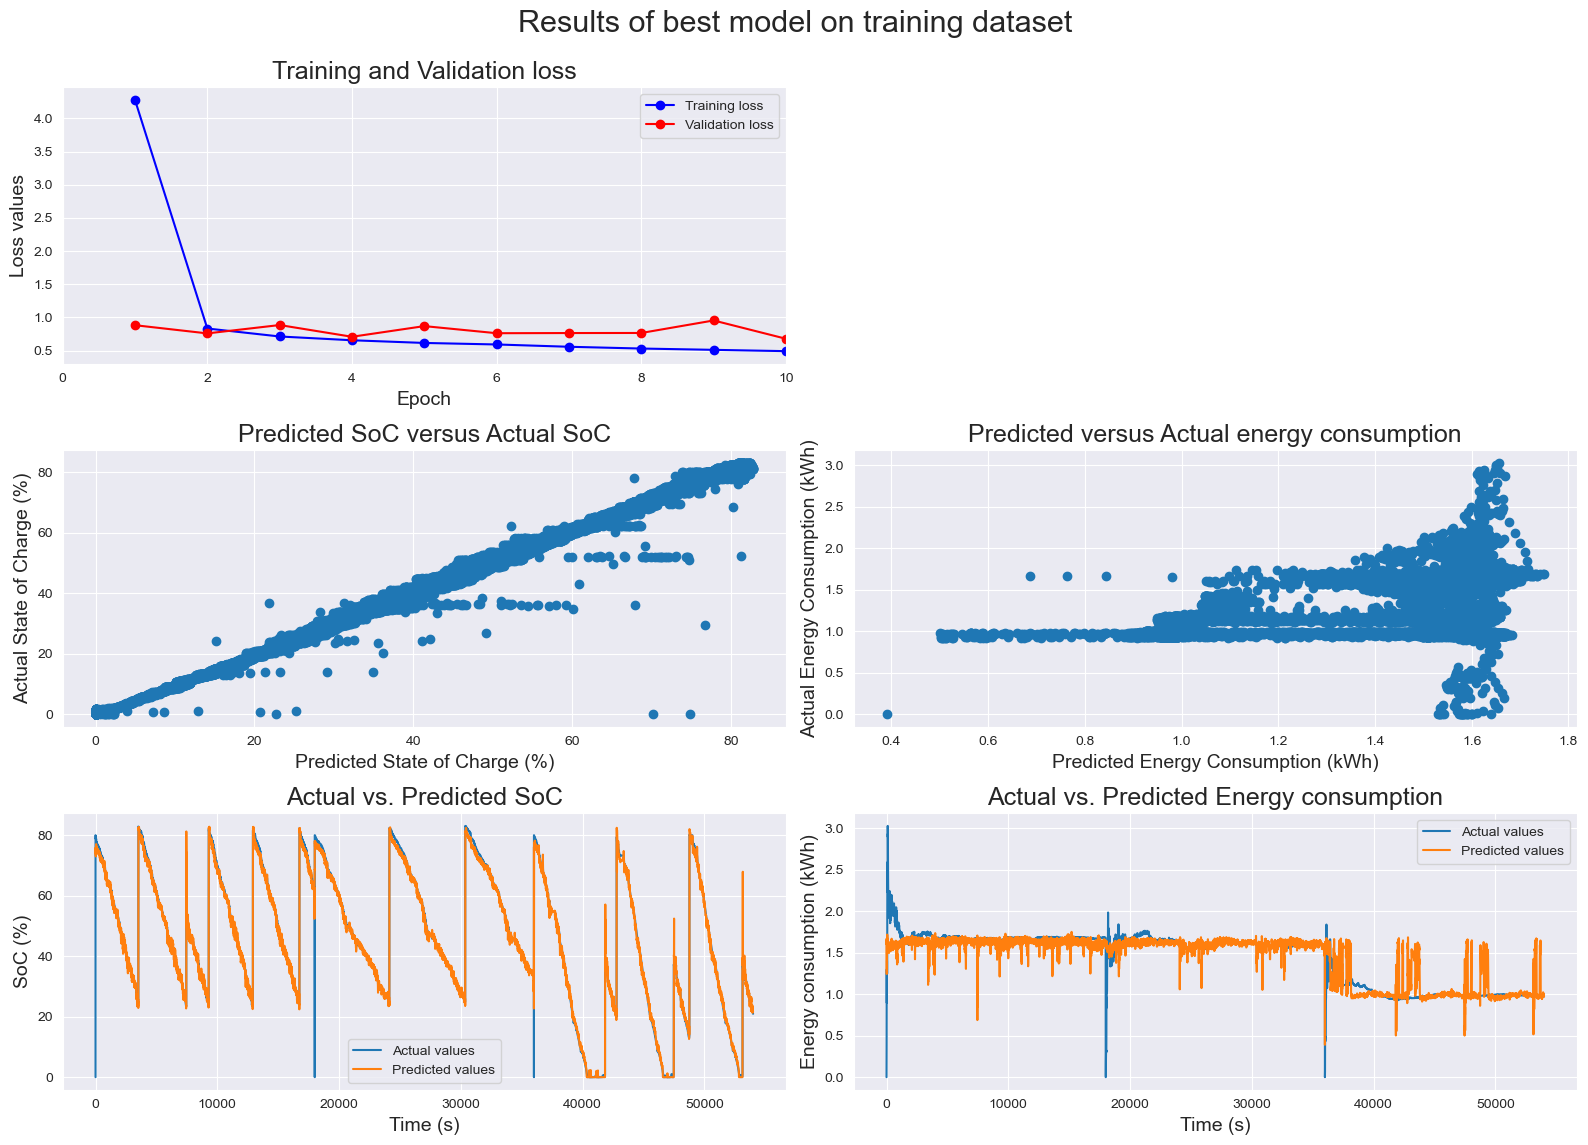

In [51]:
# Visualize predicted values in function of actual values
fig = plt.figure(figsize=(16,12))
label_size = 14

plt.subplot(3,2,1)
plt.plot(epochs, train_loss, 'bo-',label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.xlim(0,10)
plt.xlabel('Epoch', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Loss values', fontsize=label_size)
plt.title('Training and Validation loss', fontsize=18)
plt.legend()

plt.subplot(3,2,3)
plt.scatter(post_pred_train['OUT_SOC'], post_train['OUT_SOC'])
plt.xlabel('Predicted State of Charge (%)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual State of Charge (%)', fontsize=label_size)
plt.title('Predicted SoC versus Actual SoC', fontsize=18)

plt.subplot(3,2,4)
plt.scatter(post_pred_train['OUT_NRG'], post_train['OUT_NRG'])
plt.xlabel('Predicted Energy Consumption (kWh)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual Energy Consumption (kWh)', fontsize=label_size)
plt.title('Predicted versus Actual energy consumption', fontsize=18)

# Visualize actual vs predicted values in function of time
plt.subplot(3,2,5)
plt.plot(post_train['OUT_SOC'], label='Actual values')
plt.plot(post_pred_train['OUT_SOC'], label='Predicted values')
plt.title('Actual vs. Predicted SoC', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('SoC (%)', fontsize=label_size)
plt.legend()

plt.subplot(3,2,6)
plt.plot(post_train['OUT_NRG'], label='Actual values')
plt.plot(post_pred_train['OUT_NRG'], label='Predicted values')
plt.title('Actual vs. Predicted Energy consumption', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('Energy consumption (kWh)', fontsize=label_size)
plt.legend()

# Adjust layout and add the overall title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Results of best model on training dataset', fontsize=22)

plt.show()

Best recurrent neural network model
Test loss:  0.68
R²-score of State of Charge:  0.989
R²-score of Energy Consumption:  -0.8
Number of predicted charging events:  16 Actual charging events:  17


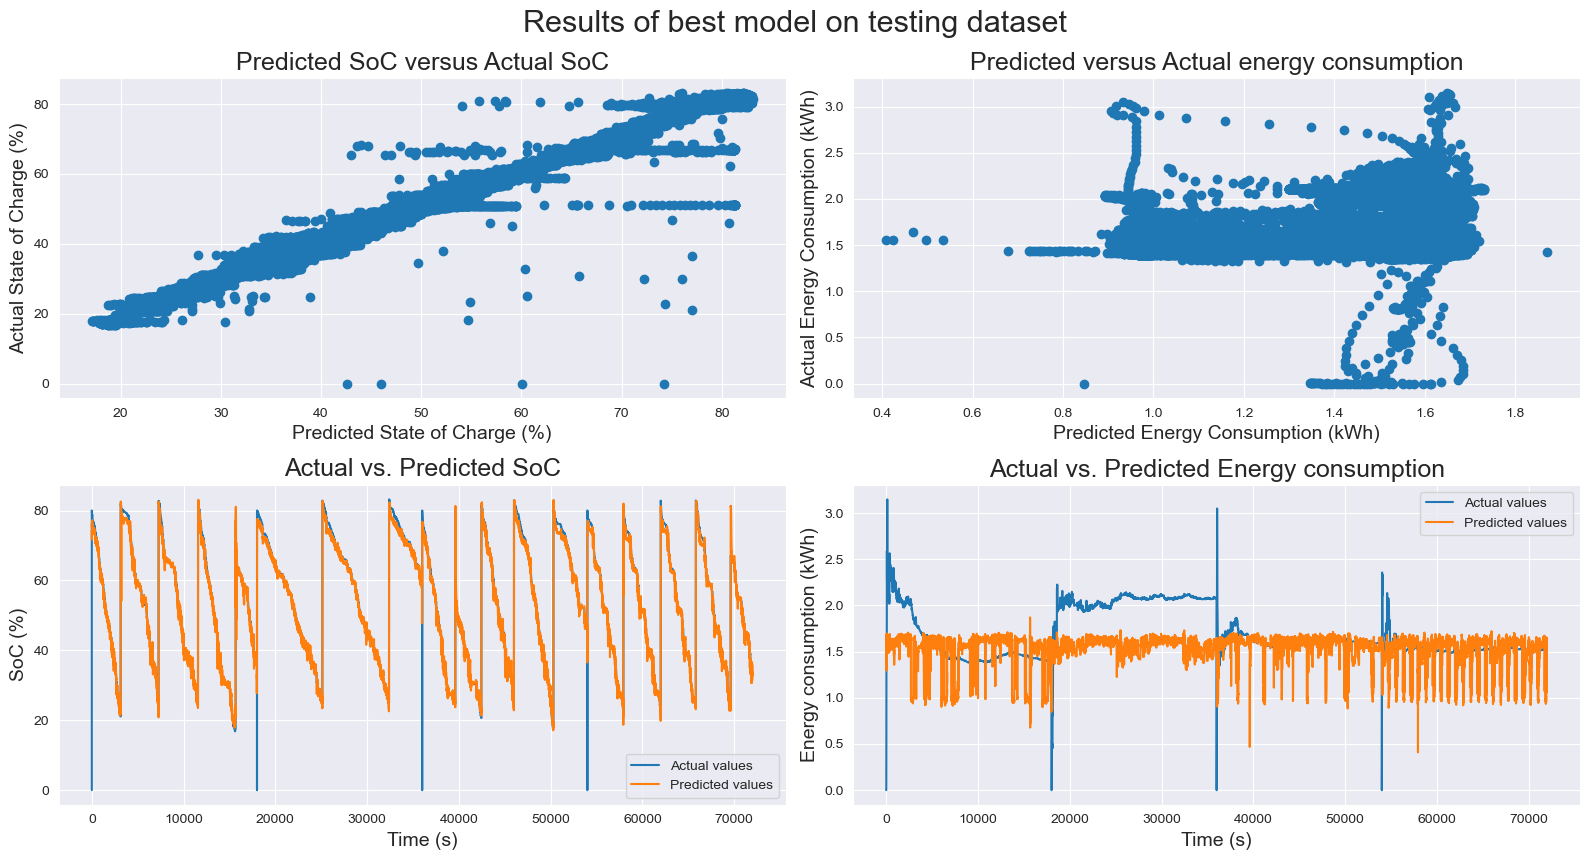

In [52]:
print("Best recurrent neural network model")
print("Test loss: ", round(test_loss,3))

post_best = pd.DataFrame(y_test, columns=output_var_list)
post_pred_best = pd.DataFrame(predictions, columns=output_var_list)

r2_soc = r2_score(post_best['OUT_SOC'], post_pred_best['OUT_SOC'])
print("R²-score of State of Charge: ", round(r2_soc,3))
r2_nrg = r2_score(post_best['OUT_NRG'], post_pred_best['OUT_NRG'])
print("R²-score of Energy Consumption: ", round(r2_nrg,3))

charg_ev = charging_events(predictions)
print("Number of predicted charging events: ", charg_ev, "Actual charging events: ", charging_events(y_test))

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Visualize predicted values in function of actual values
fig =plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
plt.scatter(post_pred_best['OUT_SOC'], post_best['OUT_SOC'])
plt.xlabel('Predicted State of Charge (%)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual State of Charge (%)', fontsize=label_size)
plt.title('Predicted SoC versus Actual SoC', fontsize=18)

plt.subplot(2,2,2)
plt.scatter(post_pred_best['OUT_NRG'], post_best['OUT_NRG'])
plt.xlabel('Predicted Energy Consumption (kWh)', fontsize=label_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('Actual Energy Consumption (kWh)', fontsize=label_size)
plt.title('Predicted versus Actual energy consumption', fontsize=18)

# Visualize actual vs predicted values in function of time
plt.subplot(2,2,3)
plt.plot(post_best['OUT_SOC'], label='Actual values')
plt.plot(post_pred_best['OUT_SOC'], label='Predicted values')
plt.title('Actual vs. Predicted SoC', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('SoC (%)', fontsize=label_size)
plt.legend()

plt.subplot(2,2,4)
plt.plot(post_best['OUT_NRG'], label='Actual values')
plt.plot(post_pred_best['OUT_NRG'], label='Predicted values')
plt.title('Actual vs. Predicted Energy consumption', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('Energy consumption (kWh)', fontsize=label_size)
plt.legend()

# Set the overall title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Results of best model on testing dataset', fontsize=22)
plt.show()

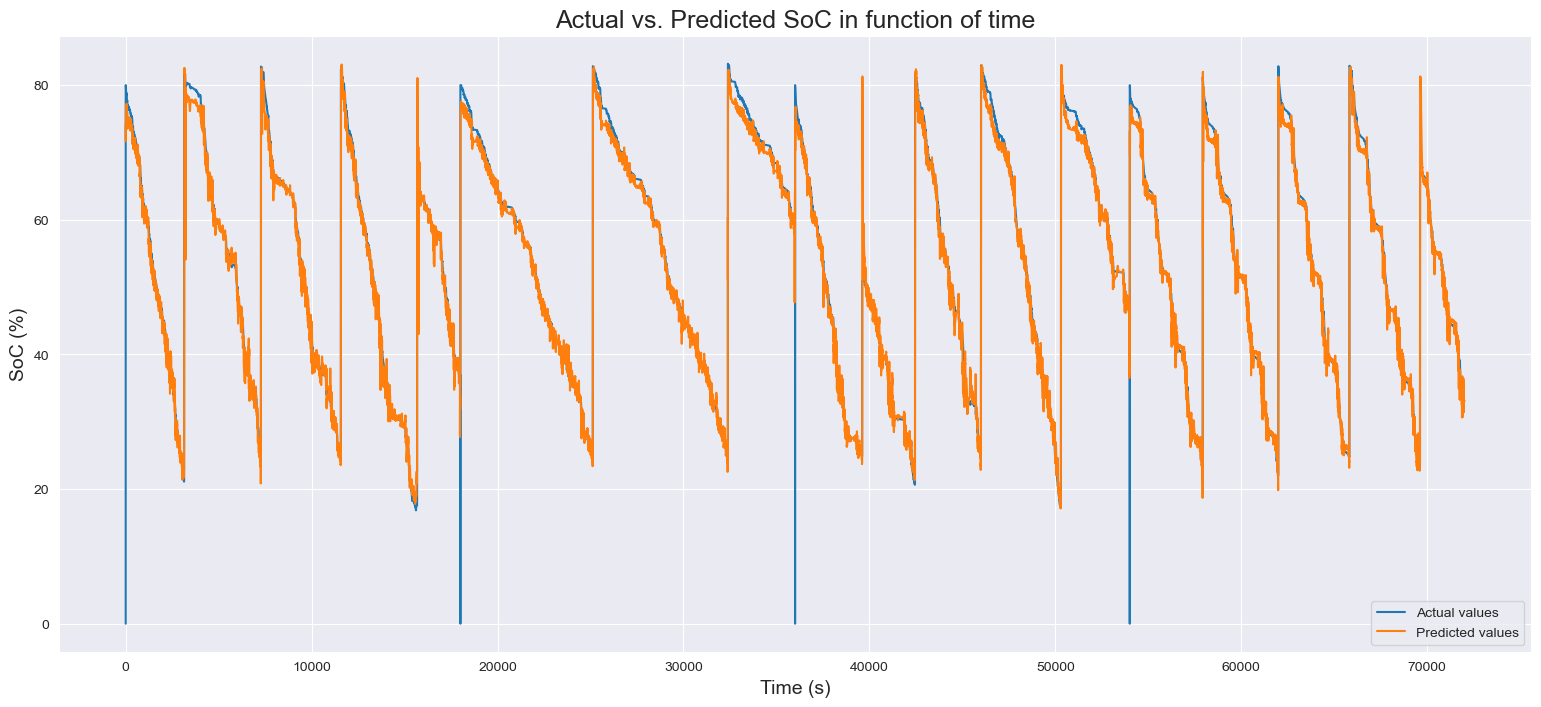

In [53]:
plt.figure(figsize=(19,8))
plt.plot(post_best['OUT_SOC'], label='Actual values')
plt.plot(post_pred_best['OUT_SOC'], label='Predicted values')
plt.title('Actual vs. Predicted SoC in function of time', fontsize=18)
plt.xlabel('Time (s)', fontsize=label_size)
plt.ylabel('SoC (%)', fontsize=label_size)
plt.legend()
plt.show()